In [1]:
import cv2
%load_ext autoreload
%autoreload 2


from torchvision import utils
import matplotlib.pyplot as plt
def show(img, title=''):
    print(img.shape, img.min(), img.max())
    plt.figure(figsize=(15,10))
    plt.imshow(img)
    plt.title(title)
    plt.show()

def show_tensor(tensor,title=''):
    img = utils.make_grid(tensor).detach().cpu().numpy().transpose(1,2,0)
    show(img, title=title)

def parse_configs(config):
    with open(config, 'r') as stream:
        try:
            configs=yaml.safe_load(stream)
            return configs
        except yaml.YAMLError as exc:
            logging.error(exc)
            return {}


In [2]:
mask = plt.imread('eval/maps/LDF/Bokeh/00156.png')
rgb = plt.imread('data/Bokeh/image/00156.jpg')

plt.imsave('../../Inpainting/lama/LaMa_test_images/00156.png', rgb)
plt.imsave('../../Inpainting/lama/LaMa_test_images/00156_mask.png', mask, cmap='gray')

In [33]:
import numpy as np
from functools import reduce

def sparse_bilateral_filtering(
    depth, image, config, HR=False, mask=None, gsHR=True, edge_id=None, num_iter=None, num_gs_iter=None, spdb=False
):
    """
    config:
    - filter_size
    """
    import time

    save_images = []
    save_depths = []
    save_discontinuities = []
    vis_depth = depth.copy()
    backup_vis_depth = vis_depth.copy()

    depth_max = vis_depth.max()
    depth_min = vis_depth.min()
    vis_image = image.copy()
    
    window_size = config["filter_size"]
    vis_image = image.copy()
    save_images.append(vis_image)
    save_depths.append(vis_depth)
    u_over, b_over, l_over, r_over = vis_depth_discontinuity(vis_depth, config, mask=mask)
    vis_image[u_over > 0] = np.array([0, 0, 0])
    vis_image[b_over > 0] = np.array([0, 0, 0])
    vis_image[l_over > 0] = np.array([0, 0, 0])
    vis_image[r_over > 0] = np.array([0, 0, 0])

    discontinuity_map = (u_over + b_over + l_over + r_over).clip(0.0, 1.0)
    discontinuity_map[depth == 0] = 1
    save_discontinuities.append(discontinuity_map)
    if mask is not None:
        discontinuity_map[mask == 0] = 0
    vis_depth = bilateral_filter(
        vis_depth, config, discontinuity_map=discontinuity_map, HR=HR, mask=mask, window_size=window_size
    )

    return save_images, save_depths


def vis_depth_discontinuity(depth, config, vis_diff=False, label=False, mask=None):
    """
    config:
    - 
    """
    if label == False:
        disp = 1./depth
        u_diff = (disp[1:, :] - disp[:-1, :])[:-1, 1:-1]
        b_diff = (disp[:-1, :] - disp[1:, :])[1:, 1:-1]
        l_diff = (disp[:, 1:] - disp[:, :-1])[1:-1, :-1]
        r_diff = (disp[:, :-1] - disp[:, 1:])[1:-1, 1:]
        if mask is not None:
            u_mask = (mask[1:, :] * mask[:-1, :])[:-1, 1:-1]
            b_mask = (mask[:-1, :] * mask[1:, :])[1:, 1:-1]
            l_mask = (mask[:, 1:] * mask[:, :-1])[1:-1, :-1]
            r_mask = (mask[:, :-1] * mask[:, 1:])[1:-1, 1:]
            u_diff = u_diff * u_mask
            b_diff = b_diff * b_mask
            l_diff = l_diff * l_mask
            r_diff = r_diff * r_mask
        u_over = (np.abs(u_diff) > config['depth_threshold']).astype(np.float32)
        b_over = (np.abs(b_diff) > config['depth_threshold']).astype(np.float32)
        l_over = (np.abs(l_diff) > config['depth_threshold']).astype(np.float32)
        r_over = (np.abs(r_diff) > config['depth_threshold']).astype(np.float32)
    else:
        disp = depth
        u_diff = (disp[1:, :] * disp[:-1, :])[:-1, 1:-1]
        b_diff = (disp[:-1, :] * disp[1:, :])[1:, 1:-1]
        l_diff = (disp[:, 1:] * disp[:, :-1])[1:-1, :-1]
        r_diff = (disp[:, :-1] * disp[:, 1:])[1:-1, 1:]
        if mask is not None:
            u_mask = (mask[1:, :] * mask[:-1, :])[:-1, 1:-1]
            b_mask = (mask[:-1, :] * mask[1:, :])[1:, 1:-1]
            l_mask = (mask[:, 1:] * mask[:, :-1])[1:-1, :-1]
            r_mask = (mask[:, :-1] * mask[:, 1:])[1:-1, 1:]
            u_diff = u_diff * u_mask
            b_diff = b_diff * b_mask
            l_diff = l_diff * l_mask
            r_diff = r_diff * r_mask
        u_over = (np.abs(u_diff) > 0).astype(np.float32)
        b_over = (np.abs(b_diff) > 0).astype(np.float32)
        l_over = (np.abs(l_diff) > 0).astype(np.float32)
        r_over = (np.abs(r_diff) > 0).astype(np.float32)
    u_over = np.pad(u_over, 1, mode='constant')
    b_over = np.pad(b_over, 1, mode='constant')
    l_over = np.pad(l_over, 1, mode='constant')
    r_over = np.pad(r_over, 1, mode='constant')
    u_diff = np.pad(u_diff, 1, mode='constant')
    b_diff = np.pad(b_diff, 1, mode='constant')
    l_diff = np.pad(l_diff, 1, mode='constant')
    r_diff = np.pad(r_diff, 1, mode='constant')

    if vis_diff:
        return [u_over, b_over, l_over, r_over], [u_diff, b_diff, l_diff, r_diff]
    else:
        return [u_over, b_over, l_over, r_over]

def bilateral_filter(depth, config, discontinuity_map=None, HR=False, mask=None, window_size=False):
    sort_time = 0
    replace_time = 0
    filter_time = 0
    init_time = 0
    filtering_time = 0
    sigma_s = config['sigma_s']
    sigma_r = config['sigma_r']
    if window_size == False:
        window_size = config['filter_size']
    midpt = window_size//2
    ax = np.arange(-midpt, midpt+1.)
    xx, yy = np.meshgrid(ax, ax)
    if discontinuity_map is not None:
        spatial_term = np.exp(-(xx**2 + yy**2) / (2. * sigma_s**2))

    # padding
    depth = depth[1:-1, 1:-1]
    depth = np.pad(depth, ((1,1), (1,1)), 'edge')
    pad_depth = np.pad(depth, (midpt,midpt), 'edge')
    if discontinuity_map is not None:
        discontinuity_map = discontinuity_map[1:-1, 1:-1]
        discontinuity_map = np.pad(discontinuity_map, ((1,1), (1,1)), 'edge')
        pad_discontinuity_map = np.pad(discontinuity_map, (midpt,midpt), 'edge')
        pad_discontinuity_hole = 1 - pad_discontinuity_map
    # filtering
    output = depth.copy()
    pad_depth_patches = rolling_window(pad_depth, [window_size, window_size], [1,1])
    if discontinuity_map is not None:
        pad_discontinuity_patches = rolling_window(pad_discontinuity_map, [window_size, window_size], [1,1])
        pad_discontinuity_hole_patches = rolling_window(pad_discontinuity_hole, [window_size, window_size], [1,1])

    if mask is not None:
        pad_mask = np.pad(mask, (midpt,midpt), 'constant')
        pad_mask_patches = rolling_window(pad_mask, [window_size, window_size], [1,1])
    from itertools import product
    if discontinuity_map is not None:
        pH, pW = pad_depth_patches.shape[:2]
        for pi in range(pH):
            for pj in range(pW):
                if mask is not None and mask[pi, pj] == 0:
                    continue
                if discontinuity_map is not None:
                    if bool(pad_discontinuity_patches[pi, pj].any()) is False:
                        continue
                    discontinuity_patch = pad_discontinuity_patches[pi, pj]
                    discontinuity_holes = pad_discontinuity_hole_patches[pi, pj]
                depth_patch = pad_depth_patches[pi, pj]
                depth_order = depth_patch.ravel().argsort()
                patch_midpt = depth_patch[window_size//2, window_size//2]
                if discontinuity_map is not None:
                    coef = discontinuity_holes.astype(np.float32)
                    if mask is not None:
                        coef = coef * pad_mask_patches[pi, pj]
                else:
                    range_term = np.exp(-(depth_patch-patch_midpt)**2 / (2. * sigma_r**2))
                    coef = spatial_term * range_term
                if coef.max() == 0:
                    output[pi, pj] = patch_midpt
                    continue
                if discontinuity_map is not None and (coef.max() == 0):
                    output[pi, pj] = patch_midpt
                else:
                    coef = coef/(coef.sum())
                    coef_order = coef.ravel()[depth_order]
                    cum_coef = np.cumsum(coef_order)
                    ind = np.digitize(0.5, cum_coef)
                    output[pi, pj] = depth_patch.ravel()[depth_order][ind]
    else:
        pH, pW = pad_depth_patches.shape[:2]
        for pi in range(pH):
            for pj in range(pW):
                if discontinuity_map is not None:
                    if pad_discontinuity_patches[pi, pj][window_size//2, window_size//2] == 1:
                        continue
                    discontinuity_patch = pad_discontinuity_patches[pi, pj]
                    discontinuity_holes = (1. - discontinuity_patch)
                depth_patch = pad_depth_patches[pi, pj]
                depth_order = depth_patch.ravel().argsort()
                patch_midpt = depth_patch[window_size//2, window_size//2]
                range_term = np.exp(-(depth_patch-patch_midpt)**2 / (2. * sigma_r**2))
                if discontinuity_map is not None:
                    coef = spatial_term * range_term * discontinuity_holes
                else:
                    coef = spatial_term * range_term
                if coef.sum() == 0:
                    output[pi, pj] = patch_midpt
                    continue
                if discontinuity_map is not None and (coef.sum() == 0):
                    output[pi, pj] = patch_midpt
                else:
                    coef = coef/(coef.sum())
                    coef_order = coef.ravel()[depth_order]
                    cum_coef = np.cumsum(coef_order)
                    ind = np.digitize(0.5, cum_coef)
                    output[pi, pj] = depth_patch.ravel()[depth_order][ind]

    return output

def rolling_window(a, window, strides):
    assert len(a.shape)==len(window)==len(strides), "\'a\', \'window\', \'strides\' dimension mismatch"
    shape_fn = lambda i,w,s: (a.shape[i]-w)//s + 1
    shape = [shape_fn(i,w,s) for i,(w,s) in enumerate(zip(window, strides))] + list(window)
    def acc_shape(i):
        if i+1>=len(a.shape):
            return 1
        else:
            return reduce(lambda x,y:x*y, a.shape[i+1:])
    _strides = [acc_shape(i)*s*a.itemsize for i,s in enumerate(strides)] + list(a.strides)

    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=_strides)

/tmp/ipykernel_1138998/2195619689.py:54: RuntimeWarning: divide by zero encountered in divide
  disp = 1./depth
/tmp/ipykernel_1138998/2195619689.py:55: RuntimeWarning: invalid value encountered in subtract
  u_diff = (disp[1:, :] - disp[:-1, :])[:-1, 1:-1]
/tmp/ipykernel_1138998/2195619689.py:56: RuntimeWarning: invalid value encountered in subtract
  b_diff = (disp[:-1, :] - disp[1:, :])[1:, 1:-1]
/tmp/ipykernel_1138998/2195619689.py:57: RuntimeWarning: invalid value encountered in subtract
  l_diff = (disp[:, 1:] - disp[:, :-1])[1:-1, :-1]
/tmp/ipykernel_1138998/2195619689.py:58: RuntimeWarning: invalid value encountered in subtract
  r_diff = (disp[:, :-1] - disp[:, 1:])[1:-1, 1:]


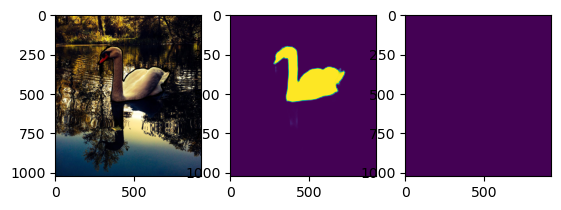

0.0


In [61]:
mask = plt.imread('eval/maps/LDF/Bokeh/00156.png')
rgb = plt.imread('data/Bokeh/image/00156.jpg')

configs = {
    'sigma_s': 4.0,
    'sigma_r': 0.5,
    'filter_size': 11,
    'depth_threshold': 0.04
}


vis, filtered_img = sparse_bilateral_filtering(mask, rgb, configs, num_iter = 1)

vis = vis[0]
filtered_img = filtered_img[0]
diff = np.abs(filtered_img - mask) 

plt.figure()
plt.subplot(1,3,1)
plt.imshow(vis)

plt.subplot(1,3,2)
plt.imshow(filtered_img)

plt.subplot(1,3,3)
plt.imshow(diff)
plt.show()

print(diff.sum())